thank Ahlad Kumar for the lesson

In [1]:
%tensorflow_version 1.x
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


In [0]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

In [0]:
!mkdir MNIST_Fashion
! cp *.gz MNIST_Fashion/

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_Fashion/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-labels-idx1-ubyte.gz
Extracting MNIST_Fashion/t10k-images-idx3-ubyte.gz
Extracting MNIST_Fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
l_rate = 0.0002
batch_size = 128
epochs = 100000

image_dim = 784
gen_hidd_dim = 256
disc_hidd_dim = 256
z_noise_dim = 100

In [0]:
def xavier_init(shape):
  return tf.random.normal(shape = shape, stddev=1./tf.sqrt(shape[0]/2.0))

In [0]:
weights = {
    'disc_H' : tf.Variable(xavier_init([image_dim, disc_hidd_dim])),
    'disc_final' : tf.Variable(xavier_init([disc_hidd_dim, 1])),
    'gen_H' : tf.Variable(xavier_init([z_noise_dim, gen_hidd_dim])),
    'gen_final' : tf.Variable(xavier_init([gen_hidd_dim, image_dim]))
}
bias = {
    'disc_H' : tf.Variable(xavier_init([disc_hidd_dim])),
    'disc_final' : tf.Variable(xavier_init([1])),
    'gen_H' : tf.Variable(xavier_init([gen_hidd_dim])),
    'gen_final' : tf.Variable(xavier_init([image_dim]))
}

In [0]:
def Discriminator(x):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, weights["disc_H"]), bias["disc_H"]))
  final_layer = tf.add(tf.matmul(hidden_layer, weights['disc_final']), bias['disc_final'])
  disc_output = tf.nn.sigmoid(final_layer)
  return final_layer, disc_output

def Generator(x):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, weights["gen_H"]), bias["gen_H"]))
  final_layer = tf.add(tf.matmul(hidden_layer, weights['gen_final']), bias['gen_final'])
  gen_output = tf.nn.sigmoid(final_layer)
  return  gen_output

In [0]:
Z_input = tf.placeholder(tf.float32, shape=[None, z_noise_dim], name = "input_noise")
X_input = tf.placeholder(tf.float32, shape=[None, image_dim], name = "real_input")

In [0]:
with tf.name_scope("Generator") as scope:
  output_Gen = Generator(Z_input)

with tf.name_scope("Discriminator") as scope:
  real_ouput1_Disc, real_output_Disc = Discriminator(X_input)
  fake_ouput1_Disc, fake_output_Disc = Discriminator(output_Gen)

In [0]:
#loss function
with tf.name_scope("Discriminator_Loss") as scope:
  Discriminator_Loss = -tf.reduce_mean(tf.log(real_output_Disc + 0.0001)+tf.log(1.- fake_output_Disc + 1e-4))
with tf.name_scope("Generator_Loss") as scope:
  Generator_Loss = -tf.reduce_mean(tf.log(fake_output_Disc+1e-4))

Disc_loss_total = tf.summary.scalar("Disc_Total_loss", Discriminator_Loss)
Gen_loss_total = tf.summary.scalar("Gen_loss", Generator_Loss)

In [12]:
with tf.name_scope("Discriminator_Loss") as scope:
  Disc_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_ouput1_Disc, labels=tf.ones_like(real_ouput1_Disc)))
  Disc_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_ouput1_Disc, labels=tf.zeros_like(fake_ouput1_Disc)))
  Discriminator_Loss = Disc_real_loss + Disc_fake_loss

with tf.name_scope("Generator_Loss") as scope:
  Generator_Loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_ouput1_Disc, labels=tf.ones_like(fake_ouput1_Disc)))

Disc_loss_real_summary = tf.summary.scalar("Disc_loss_real", Disc_real_loss)
Disc_loss_fake_summary = tf.summary.scalar("Disc_loss_fake", Disc_fake_loss)
Disc_loss_summary = tf.summary.scalar("Disc_Titak_loss", Discriminator_Loss)

Disc_loss_total = tf.summary.merge([Disc_loss_real_summary, Disc_loss_fake_summary, Disc_loss_summary])
Gen_loss_total = tf.summary.scalar('Gen_Loss', Generator_Loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
Generator_var = [weights['gen_H'],weights['gen_final'],bias['gen_H'],bias['gen_final']]
Discriminator_var = [weights['disc_H'],weights['disc_final'],bias['disc_H'],bias['disc_final']]

with tf.name_scope("Optimizer_Discriminator") as scope:
  Discriminator_optimize = tf.train.AdamOptimizer(learning_rate=l_rate).minimize(Discriminator_Loss, var_list= Discriminator_var)
with tf.name_scope("Optimizer_Generator") as scope:
  Generator_optimize = tf.train.AdamOptimizer(learning_rate=l_rate).minimize(Generator_Loss, var_list= Generator_var)

In [15]:
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
writer = tf.summary.FileWriter("./log", sess.graph)

for epoch in range(epochs):
  X_batch, _ = mnist.train.next_batch(batch_size)

  Z_noise = np.random.uniform(-1.,1.,size = [batch_size, z_noise_dim])
  _,Disc_loss_epoch = sess.run([Discriminator_optimize, Discriminator_Loss], feed_dict= {X_input:X_batch, Z_input:Z_noise})
  _,Gen_loss_epoch = sess.run([Generator_optimize, Generator_Loss], feed_dict={Z_input:Z_noise})

  summary_Disc_loss = sess.run(Disc_loss_total, feed_dict={X_input:X_batch,Z_input:Z_noise})
  writer.add_summary(summary_Disc_loss, epoch)

  summary_Gen_loss = sess.run(Gen_loss_total, feed_dict={Z_input:Z_noise})
  writer.add_summary(summary_Gen_loss, epoch)

  if epoch % 2000 == 0:
    print('Steps {0} : Generator loss {1}, Discriminator Loss {2}'.format(epoch, Gen_loss_epoch, Disc_loss_epoch))

Steps 0 : Generator loss 2.4690747261047363, Discriminator Loss 2.0943517684936523
Steps 2000 : Generator loss 4.368954658508301, Discriminator Loss 0.06497862935066223
Steps 4000 : Generator loss 2.7558047771453857, Discriminator Loss 0.24593329429626465
Steps 6000 : Generator loss 2.78371524810791, Discriminator Loss 0.23011139035224915
Steps 8000 : Generator loss 2.0220794677734375, Discriminator Loss 0.37857580184936523
Steps 10000 : Generator loss 2.562833309173584, Discriminator Loss 0.4655939042568207
Steps 12000 : Generator loss 2.2504100799560547, Discriminator Loss 0.5277045965194702
Steps 14000 : Generator loss 2.5234756469726562, Discriminator Loss 0.49328386783599854
Steps 16000 : Generator loss 2.36086368560791, Discriminator Loss 0.6760236024856567
Steps 18000 : Generator loss 2.2229862213134766, Discriminator Loss 0.6514117121696472
Steps 20000 : Generator loss 2.7290544509887695, Discriminator Loss 0.46442458033561707
Steps 22000 : Generator loss 3.0115013122558594, Di

<function matplotlib.pyplot.show>

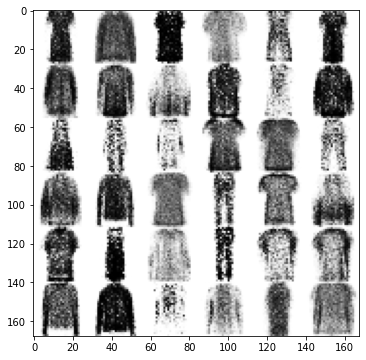

In [18]:
#testing
n = 6
canvas = np.empty((28*n, 28*n))
for i in range(n):
  z_noise = np.random.uniform(-1.,1., size=[batch_size,z_noise_dim])
  g = sess.run(output_Gen, feed_dict={Z_input:z_noise})
  g = -1 * (g-1)
  for j in range(n):
    canvas[i*28:(i+1)*28,j*28:(j+1)*28] = g[j].reshape([28,28])
plt.figure(figsize=(n,n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show